In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [14]:
def getdfs(data : str, train_size : float = 1):
    '''
    preprocess and return train_df and val_df
    '''
    if data not in ['text_seq', 'feature' , 'emoticon']:
        raise ValueError("Invalid data type")
    
    if data == 'feature' : 
        train_df = np.load(f"/Users/siya/Desktop/datasets/train/train_{data}.npz") #for my laptop
        valid_df = np.load(f"/Users/siya/Desktop/datasets/valid/valid_{data}.npz")
    else :
        train_df = pd.read_csv(f"/Users/siya/Desktop/datasets/train/train_{data}.csv")
        val_df = pd.read_csv(f"/Users/siya/Desktop/datasets/valid/valid_{data}.csv")
    
    train_df = train_df[:int(len(train_df)*train_size)]

    def get_char_columns(df):
        for i in range(len(df['input_emoticon'][0])):
            df[f'c_{i+1}'] = df['input_emoticon'].apply(lambda x, _i=i: x[_i])
        
        return df[df.columns.to_list()[2:] + ['label']]

    if data == 'emoticon':
        train_df = get_char_columns(train_df)
        val_df = get_char_columns(val_df)

    return train_df, val_df

In [15]:

from transformers import AutoTokenizer, AutoModel
import torch
import demoji

train_df, val_df = getdfs('emoticon')

for i in range(13) :
    train_df[f'c_{i+1}_text'] = train_df[f'c_{i+1}'].apply(lambda x: demoji.replace_with_desc(x)[1:-1] if x != '' else x)
    val_df[f'c_{i+1}_text'] = val_df[f'c_{i+1}'].apply(lambda x: demoji.replace_with_desc(x)[1:-1] if x != '' else x)


tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

def text2embed(text) :
    inputs = tokenizer(text, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    embeddings = outputs.last_hidden_state
    sentence_embedding = torch.mean(embeddings, dim=1)

    return sentence_embedding.numpy().reshape(-1)

texts = []
for i in range(13) :
    for text in train_df[f'c_{i+1}_text'] :
        texts.append(text)
texts = list(set(texts))

dict_text2bed = {f'{text}' : text2embed(text) for text in texts}

def embed_df(df : pd.DataFrame, embedding_dim : int = 768, num_columns: int = 13)-> pd.DataFrame :

    # Initialize a list to store rows of combined embeddings
    combined_embeddings = []

    # Iterate over each row in the dataframe
    for idx, row in df.iterrows():
        row_embeddings = []
        
        # Iterate over the 13 columns and get the embedding for each
        for i in range(num_columns):
            column_text = row[f'c_{i+1}_text']
            
            # If the text is not empty, fetch its embedding, else use a zero vector
            if column_text != '':
                embedding = dict_text2bed.get(column_text, np.zeros(embedding_dim))
            else:
                embedding = np.zeros(embedding_dim)
            
            # Append the embedding to the row list
            row_embeddings.append(embedding)
        
        # Concatenate the embeddings for the row
        combined_embeddings.append(np.hstack(row_embeddings))

    # Convert the list of rows into a NumPy array
    X = np.vstack(combined_embeddings)
    
    return X

train_feat_X1 = embed_df(train_df)
train_feat_Y1 = train_df['label']

valid_feat_X1 = embed_df(val_df)
valid_feat_Y1 = val_df['label']

In [16]:
train_feat_X1.shape

(7080, 9984)

In [17]:
# Read feature dataset
train_feat = np.load("/Users/siya/Desktop/datasets/train/train_feature.npz", allow_pickle=True)
val_feat = np.load("/Users/siya/Desktop/datasets/valid/valid_feature.npz", allow_pickle=True)
train_feat_X2 = train_feat['features']
train_feat_Y2 = train_feat['label']
valid_feat_X2 = val_feat['features']
valid_feat_Y2 = val_feat['label']

In [18]:
train_feat_X2 = train_feat_X2.reshape(7080, -1)
print(train_feat_X2.shape)

(7080, 9984)


### Pearson correlation coefficent 

In [19]:
import numpy as np

# Assuming array_A and array_B are numpy arrays of size (7080, 9984)
# Calculate the correlation matrix for each pair of features
correlation = np.corrcoef(train_feat_X1.T, train_feat_X2.T)
# Extract the submatrix for the correlation between array_A and array_B features
corr_AB = correlation[:9984, 9984:]


/Users/siya/CS771 mini project /myproject_env/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/siya/CS771 mini project /myproject_env/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [20]:
corr_AB

array([[            nan,             nan,             nan, ...,
         7.09105969e-03,  1.13162816e-03,  4.05267097e-03],
       [            nan,             nan,             nan, ...,
         1.23080497e-02,  6.50441495e-03, -1.92544604e-03],
       [            nan,             nan,             nan, ...,
        -1.62889352e-02, -5.38681204e-03,  2.05833585e-03],
       ...,
       [            nan,             nan,             nan, ...,
         1.14517898e-02,  4.20938438e-05,  6.10693398e-03],
       [            nan,             nan,             nan, ...,
         5.84730057e-02, -5.33155678e-02,  7.34278022e-03],
       [            nan,             nan,             nan, ...,
         1.36496881e-02, -8.52363497e-03,  6.72855509e-02]])

### Linear Regression 

In [21]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_feat_X1, train_feat_X2)

# Check the R^2 score for the prediction
r2_score = model.score(train_feat_X1, train_feat_X2)
print(f"R^2 score: {r2_score}")


R^2 score: 0.9501838798419456


In [28]:
coefficients = model.coef_
intercept = model.intercept_
print("Coefficients:", coefficients)
print("intercept:", intercept)


Coefficients: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-6.40641328e+10  3.31636862e+10 -2.10190165e+10 ... -1.71228638e+09
  -1.49767322e+08 -5.81321431e+09]
 [ 6.40261168e+09  5.73462636e+10 -6.93818561e+10 ...  3.49512293e+08
  -6.93609359e+09  9.80095734e+08]
 [-3.78052007e+10 -6.15694696e+10  3.76687789e+10 ... -1.56269726e+09
   4.23913481e+09  2.07503420e+09]]
intercept: [-6.86228946e-02 -2.02977415e-02  6.44705519e-02 ...  1.44147160e+10
 -1.03533136e+11  2.47739954e+11]


In [24]:
import numpy as np

predictions = model.predict(train_feat_X1)
print("First 5 Actual values of array_B:\n", train_feat_X2[:5])
print("First 5 Predicted values:\n", predictions[:5])


First 5 Actual values of array_B:
 [[-0.06862289 -0.02029774  0.06447055 ... -0.02888818  0.01680396
   0.08289439]
 [-0.06862289 -0.02029774  0.06447055 ...  0.14048833 -0.02094931
  -0.00344788]
 [-0.06862289 -0.02029774  0.06447055 ...  0.04369658 -0.00869946
   0.00046251]
 [-0.06862289 -0.02029774  0.06447055 ... -0.05947836  0.08291107
  -0.02483253]
 [-0.06862289 -0.02029774  0.06447055 ...  0.14048833 -0.02094931
  -0.00344788]]
First 5 Predicted values:
 [[-0.06862289 -0.02029774  0.06447055 ... -0.05444527  0.02497864
   0.07116699]
 [-0.06862289 -0.02029774  0.06447055 ...  0.15086365 -0.00799561
   0.00744629]
 [-0.06862289 -0.02029774  0.06447055 ...  0.0477829  -0.00387573
  -0.0171814 ]
 [-0.06862289 -0.02029774  0.06447055 ...  0.02016449  0.045578
  -0.02502441]
 [-0.06862289 -0.02029774  0.06447055 ...  0.11522293 -0.00656128
  -0.01596069]]


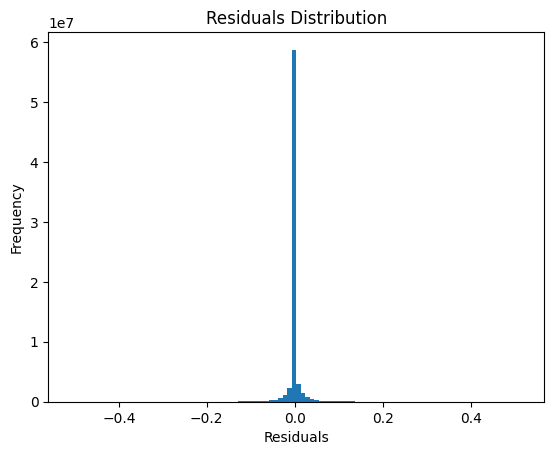

In [26]:
import matplotlib.pyplot as plt

residuals = train_feat_X2 - predictions
plt.hist(residuals.flatten(), bins=100)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()
